# 导入第三方库

In [2]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from random import *
from math import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from collections import Counter
from itertools import cycle
from sklearn import svm, datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import tensorflow as tf
import matplotlib as mpl
import seaborn as sns

# 数据输入和准备

In [2]:
otu_label = pd.read_csv("1285otu_all.csv",index_col=0,sep = "\t")
otu_label
label = pd.read_csv("286label",sep = "\t",index_col=0)
label = label["true"]
otu_286 = otu_label[otu_label.index.isin(label.index)] 
label

sample
NH1      XR
NH2      JZ
NH3      FJ
NH4      CR
NH5      XR
         ..
NH283    JK
NH284    JK
NH285    CR
NH286    FJ
NH287    CR
Name: true, Length: 286, dtype: object

In [4]:
otu_label = pd.read_csv("genusdata_filter0318.csv",index_col=0,sep = ",")
otu_label

,label,Eubacterium,Flavonifractor,Butyricimonas,Collinsella,Lachnospiracea_incertae_sedis,Megamonas,Dialister,Coprococcus,Clostridium_XlVb,...,Ruminococcus,Clostridium_XVIII,Desulfovibrio,Streptococcus,Anaerotruncus,Ruminococcus2,Intestinibacter,Phascolarctobacterium,Bilophila,Barnesiella
Sample,,,,,,,,,,,,,,,,,,,,,
CR001,CR,0.131330,0.167930,0.012918,0.032294,0.772907,0.798743,0.409060,0.191612,0.372460,...,0.105494,0.092577,0.012918,0.058130,0.045212,0.376765,0.012918,3.044265,0.137788,0.049518
CR002,CR,0.247556,0.153656,0.040548,0.012805,1.999659,0.738401,0.070426,0.241154,0.288104,...,0.113108,0.044816,0.012805,0.046950,0.040548,0.808827,0.012805,2.198131,0.134449,0.000000
CR003,CR,0.111027,0.159879,0.093263,0.088822,0.981481,0.250922,0.079940,0.626194,0.386375,...,0.135453,0.193187,0.055514,0.135453,0.026647,0.495181,0.013323,0.832704,0.168761,0.017764
CR004,CR,0.198546,0.153593,0.191054,0.093654,1.423541,0.179816,1.640818,0.696786,0.520716,...,0.543193,0.153593,0.213531,0.670563,0.131116,1.273694,0.018731,1.393572,0.082416,0.018731
CR005,CR,0.238017,0.136683,0.047132,0.438328,4.856954,0.207381,0.940284,0.744686,0.648065,...,1.340906,0.263939,0.035349,0.608003,0.212094,2.712448,0.021209,0.648065,0.160249,0.082481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XRK01,PL,1.231013,0.206634,0.002198,0.019784,2.675254,1.428854,2.305951,0.624299,0.481414,...,0.441846,0.244004,0.037370,0.002198,0.010991,0.353916,0.010991,0.846321,0.019784,0.131894
XRK02,PL,0.126260,0.008560,0.000000,0.077040,0.169060,0.389480,0.012840,0.019260,0.006420,...,0.049220,0.042800,0.008560,0.006420,0.000000,0.100580,0.002140,2.910398,0.000000,0.002140
XRK03,PL,0.958486,0.368966,0.002061,0.445232,1.818032,1.218205,0.169023,0.129859,0.018551,...,0.272086,0.098941,0.012368,0.004123,0.000000,0.113369,0.010306,0.022674,0.008245,0.008245


In [5]:
otu_label=pd.concat([label, otu_286], axis=1)
otu_label.index

Index(['NH1', 'NH2', 'NH3', 'NH4', 'NH5', 'NH6', 'NH7', 'NH8', 'NH9', 'NH10',
       ...
       'NH278', 'NH279', 'NH280', 'NH281', 'NH282', 'NH283', 'NH284', 'NH285',
       'NH286', 'NH287'],
      dtype='object', name='sample', length=286)

In [24]:
label[label=="XR"] = "FJ"
label[label=="JZ"] = "CR"
Counter(label)

Counter({'FJ': 95, 'CR': 104, 'JK': 87})

In [29]:
##-------------------定义特征筛选函数3-----------------
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def filter(otu_f,thread):
    n = len(otu_f)
    columns = otu_f.columns
    # 删除表达低的特征并对样本进行归一化
    for col in columns:
        more_thread = round(len(otu_f.loc[otu_f[col]>thread,col])/n,2)*100
        if more_thread < 10:
            otu_f.drop(col,axis=1,inplace=True)
    mm = MinMaxScaler()
    mm_data = mm.fit_transform(np.transpose(otu_f))
    otu_result = pd.DataFrame(np.transpose(mm_data))
    otu_result.columns = otu_f.columns     
    return otu_result
otu_filter = otu_286
otu_filter = filter(otu_filter,10)
otu_filter.index = otu_286.index
otu_label=pd.concat([label, otu_filter], axis=1)

In [51]:
def normalization(input_data):
    x = input_data.copy() 
    n = x.shape[1]
    for i in range(n):
        x.iloc[:, i] = (x.iloc[:, i]-np.min(x.iloc[:, i]))/(np.max(x.iloc[:, i])-np.min(x.iloc[:, i]))
    return x

In [52]:
test = normalization(np.transpose(otu_286))
test.max(axis=0)

sample
NH1      1.0
NH10     1.0
NH100    1.0
NH101    1.0
NH102    1.0
        ... 
NH95     1.0
NH96     1.0
NH97     1.0
NH98     1.0
NH99     1.0
Length: 286, dtype: float64

In [34]:
otu_286

,Otu1,Otu10,Otu100,Otu101,Otu1024,Otu103,Otu104,Otu105,Otu106,Otu107,...,Otu92,Otu929,Otu93,Otu94,Otu944,Otu95,Otu96,Otu97,Otu98,Otu99
sample,,,,,,,,,,,,,,,,,,,,,
NH1,5.0,467.0,198.0,711.0,0.0,12.0,30.0,0.0,76.0,0.0,...,2.0,0.0,2036.0,0.0,0.0,12.0,0.0,2.0,0.0,0.0
NH10,18.0,198.0,0.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,33.0,192.0,84.0,0.0,675.0,0.0,0.0
NH100,5.0,286.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,2144.0,0.0,0.0,357.0,0.0,0.0,23.0,0.0,722.0,0.0
NH101,18121.0,0.0,59.0,0.0,0.0,0.0,0.0,42.0,31.0,7.0,...,0.0,0.0,0.0,13.0,0.0,58.0,0.0,66.0,0.0,0.0
NH102,5625.0,166.0,80.0,0.0,0.0,0.0,8.0,0.0,3.0,37.0,...,0.0,0.0,0.0,0.0,54.0,19.0,0.0,12.0,57.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NH95,23.0,3.0,7.0,10.0,0.0,100.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,742.0,0.0,0.0,3027.0,74.0,13.0,615.0
NH96,2.0,2.0,6.0,2.0,0.0,171.0,0.0,2.0,0.0,3.0,...,0.0,128.0,8.0,55.0,0.0,0.0,6.0,1154.0,0.0,232.0
NH97,2857.0,275.0,99.0,0.0,0.0,19.0,7.0,16.0,3.0,73.0,...,0.0,0.0,0.0,1.0,0.0,6.0,177.0,7.0,0.0,0.0


In [65]:
otu_label=pd.concat([label, otu_filter], axis=1)
otu_label

# 数据基本描述统计

Number of features: 562
string variable: 1
 <=300 unique number: 561 
 >300 unique number: 0



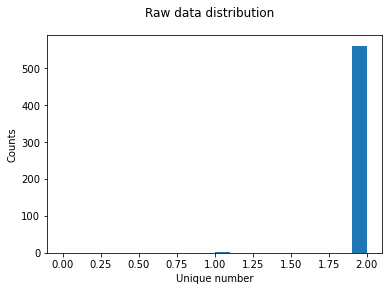

In [74]:
##-------------------所有数据的基本描述统计--------------------
##样本类别的统计和描述
otu_label["label"].describe()
values = otu_label["label"]
value_cnt = {}  # 将结果用一个字典存储
# 统计结果
for value in values:
    # get(value, num)函数的作用是获取字典中value对应的键值, num=0指示初始值大小。
    value_cnt[value] = value_cnt.get(value, 0) + 1
# 打印输出结果
# print(value_cnt)

##特征筛选和描述统计
# otu_label=pd.concat([label, otu_filter], axis=1)

cols = [c for c in otu_label.columns]   #返回数据的列名到列表里
print('Number of features: {}'.format(len(cols)))

##查看特征的数值范围
feature_numbers = [[],[],[]]
counts = [[], [], []]
for c in cols:
    typ = otu_label[c].dtype
    uniq = len(np.unique(otu_label[c]))         
    if uniq == 5 and typ == np.object:                                      
        counts[0].append(c)
        feature_numbers[0].append(uniq)
    elif uniq <= 300 and  typ == np.int32 :  
        counts[1].append(c)
        feature_numbers[1].append(uniq)
    else:
        counts[2].append(c)
        feature_numbers[2].append(uniq)
    
plt.hist(feature_numbers[1])
plt.hist(feature_numbers[2])
plt.xlabel("Unique number")
plt.ylabel("Counts")
plt.suptitle("Raw data distribution")

print('string variable: {}\n <=300 unique number: {} \n >300 unique number: {}\n'.format(*[len(c) for c in counts]))
# print('string variables:', counts[0])
# print('<=300 unique number:', counts[1])
# print('>300 unique number:', counts[2])

# 训练集和测试集划分

In [67]:
##---------训练集和测试集划分---------未考虑测序批次
#train
# otu_label = pd.read_csv("otutab_norm.csv",header=0)
X=otu_label.drop(['true'], axis=1)# Features
y=otu_label['true']
# otu_label.to_csv("otutab_norm.csv",index=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2050,shuffle=True)
X_train

,Otu1,Otu10,Otu100,Otu101,Otu1024,Otu103,Otu104,Otu105,Otu106,Otu107,...,Otu92,Otu929,Otu93,Otu94,Otu944,Otu95,Otu96,Otu97,Otu98,Otu99
sample,,,,,,,,,,,,,,,,,,,,,
NH64,2.0,3.0,124.0,0.0,0.0,0.0,0.0,5.0,6.0,6.0,...,0.0,0.0,0.0,225.0,0.0,550.0,0.0,906.0,38.0,0.0
NH258,14.0,27.0,1.0,0.0,0.0,171.0,1.0,0.0,220.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
NH131,1996.0,1.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,19.0,0.0,0.0,1.0,3.0,0.0,1.0
NH65,4926.0,57.0,115.0,1.0,1.0,1.0,1.0,55.0,7.0,1.0,...,1.0,0.0,0.0,3.0,48.0,87.0,0.0,0.0,0.0,0.0
NH266,15.0,1024.0,180.0,20.0,0.0,4.0,1.0,189.0,7.0,24.0,...,0.0,1.0,0.0,0.0,0.0,9.0,0.0,733.0,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NH36,5248.0,0.0,102.0,1.0,0.0,0.0,8.0,0.0,1.0,10.0,...,3.0,0.0,29.0,0.0,0.0,26.0,1.0,0.0,1.0,0.0
NH137,3862.0,1.0,36.0,0.0,0.0,1.0,35.0,6.0,0.0,0.0,...,0.0,0.0,0.0,108.0,0.0,0.0,0.0,0.0,0.0,1.0
NH52,18.0,382.0,1371.0,4409.0,0.0,13.0,0.0,0.0,677.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,164.0,0.0


In [30]:
#---------训练集和测试集划分---------考虑测序批次
X=otu_label.drop(['label'], axis=1)# Features
y=otu_label['label']
batch1=pd.read_table("batch1.txt",header=None)
batch2=pd.read_table('batch2.2.txt',header=None)

otu_label_batch1=otu_label[otu_label.index.isin(list(batch1[0]))] ##按照列名进行匹配
otu_label_batch2=otu_label[otu_label.index.isin(list(batch2[0]))]
X_test = otu_label_batch2.drop(['label'], axis=1)# Features
y_test = otu_label_batch2['label']
X_train = otu_label_batch1.drop(['label'], axis=1)# Features
y_train = otu_label_batch1['label']
# X_test.head()
# X_test._stat_axis.values.tolist() ##row names
#X_train.to_csv('X_train.csv',index=1)
#X_test.to_csv('X_test.csv',index=1)

In [24]:
X_test[0:13]

,Otu133,Otu2,Otu159,Otu138,Otu37,Otu13,Otu26,Otu60,Otu4,Otu112,...,Otu317,Otu428,Otu439,Otu289,Otu336,Otu421,Otu481,Otu344,Otu469,Otu151
CR001,1.000000,0.182246,0.384874,0.017097,0.017769,0.067717,0.105570,0.008138,0.023294,0.011946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CR002,0.005879,0.552312,0.008370,0.002292,0.031487,0.025907,0.100438,0.012356,0.268035,0.181048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CR003,0.064355,0.455055,0.041935,0.006228,0.070999,0.228773,0.067262,0.032385,0.303924,0.051277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CR004,0.059600,0.183400,0.012400,0.010600,0.016000,0.043600,0.031200,0.020400,0.137800,0.018600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CR005,0.058086,0.408806,0.058933,0.007451,0.017612,0.023878,0.046401,0.313124,0.224047,0.020322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CR006,0.014555,0.641909,0.013913,0.004709,0.057791,0.214041,0.141695,0.022902,0.370505,0.070634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CR007,0.010535,1.000000,0.105914,0.003793,0.112375,0.017840,0.018542,0.016575,0.213654,0.017137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CR008,0.032309,1.000000,0.128708,0.012182,0.116525,0.134004,0.090572,0.068326,0.275424,0.080508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CR009,0.109803,1.000000,0.091025,0.016868,0.047422,0.404201,0.112985,0.050286,0.696372,0.033418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CR010,0.000246,0.335427,0.000246,0.020441,0.085088,0.124861,0.101712,0.025982,0.142963,0.008250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 模型构建及参数调优 

模型一：随机森林

In [73]:
param = {
    'n_estimators':range(100,140,1),
    'max_features':range(10,30,1)
}
gsearch1 = GridSearchCV(estimator=RandomForestClassifier(random_state=2050),
                        param_grid = param,
                        cv=5,n_jobs=-1)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2050),
             n_jobs=-1,
             param_grid={'max_features': range(10, 30),
                         'n_estimators': range(100, 140)})

In [75]:
best_estimator = gsearch1.best_estimator_
#best_estimator = RandomForestClassifier(max_features=8, n_estimators=750, random_state=2050)
print(f'best params:{gsearch1.best_params_}')
print('best accuracy:%f' % gsearch1.best_score_)
print(best_estimator)

best params:{'max_features': 22, 'n_estimators': 120}
best accuracy:0.469372
RandomForestClassifier(max_features=22, n_estimators=120, random_state=2050)


In [76]:
#对训练集进行交叉验证
scores = cross_val_score(best_estimator, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Accuracy: 0.47 (+/- 0.12)


In [77]:
scores

array([0.39130435, 0.56521739, 0.43478261, 0.48888889, 0.46666667])

In [80]:
#对测试集进行测试
best_estimator.fit(X_train,y_train)
#y_pred=best_estimator.predict_proba(X_test)
y_pred=best_estimator.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.43103448275862066


In [81]:
X_test

,Otu1,Otu10,Otu100,Otu101,Otu1024,Otu103,Otu104,Otu105,Otu106,Otu107,...,Otu92,Otu929,Otu93,Otu94,Otu944,Otu95,Otu96,Otu97,Otu98,Otu99
sample,,,,,,,,,,,,,,,,,,,,,
NH130,7163.0,93.0,67.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0
NH229,1316.0,0.0,0.0,0.0,1.0,28.0,34.0,0.0,1.0,13.0,...,0.0,4.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,226.0
NH21,1595.0,0.0,36.0,0.0,18.0,0.0,146.0,0.0,503.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,24.0,0.0,0.0,0.0
NH6,0.0,66.0,0.0,171.0,0.0,13.0,0.0,0.0,46.0,33.0,...,20.0,0.0,0.0,0.0,0.0,0.0,604.0,0.0,0.0,394.0
NH96,2.0,2.0,6.0,2.0,0.0,171.0,0.0,2.0,0.0,3.0,...,0.0,128.0,8.0,55.0,0.0,0.0,6.0,1154.0,0.0,232.0
NH126,935.0,35.0,0.0,0.0,0.0,0.0,93.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,65.0,0.0
NH183,586.0,9.0,83.0,1.0,81.0,0.0,42.0,0.0,13.0,6.0,...,1.0,1.0,0.0,2.0,0.0,39.0,0.0,375.0,0.0,0.0
NH71,37.0,4.0,87.0,3.0,0.0,3.0,3.0,101.0,0.0,116.0,...,0.0,0.0,0.0,0.0,16.0,11.0,127.0,0.0,1.0,5.0
NH269,3880.0,1528.0,35.0,137.0,0.0,0.0,19.0,113.0,40.0,0.0,...,1.0,27.0,0.0,127.0,0.0,7.0,2.0,4.0,1.0,714.0


In [82]:
y_train.value_counts()

JK    69
CR    45
JZ    43
FJ    36
XR    35
Name: true, dtype: int64

In [83]:
y_test.value_counts()

JK    18
XR    18
CR    12
FJ     6
JZ     4
Name: true, dtype: int64

In [84]:
y_test_pred=best_estimator.predict_proba(X_test)

In [85]:
# nn = pd.DataFrame(pd.concat([pd.DataFrame(y_test_pred,columns=['CR','FJ','JK','JZ','XR']),
#                              pd.DataFrame(y_test.values,columns=['True_label']),
#                             pd.DataFrame(y_test._stat_axis.values.tolist(),columns=['Sample']),
#                             pd.DataFrame(y_pred,columns=['Pred_label'])
#                             ],axis=1))
# nn.head()
# nn.to_csv('y_test_pred.csv',index=0)

In [48]:
alldata = pd.DataFrame(pd.concat([pd.DataFrame(y_test._stat_axis.values.tolist(),columns=['Sample']),
                             pd.DataFrame(y_test.values,columns=['True_label']),
                             pd.DataFrame(y_pred,columns=['Pred_label']),
                             pd.DataFrame(np.array(X_test),columns=X_test.columns)
                            ],axis=1))

In [87]:
# alldata.to_csv('alldata.csv',index=0)

In [88]:
# predict_probs = best_estimator.predict_proba(X)
# all_probs = pd.concat([pd.DataFrame(X.index),pd.DataFrame(predict_probs,columns=['JK','JZ','CR'])],axis=1)
# all_probs[:10].to_csv('all_probs_text.csv',index=0)

In [49]:
importance = best_estimator.feature_importances_
feature_imp = pd.Series(importance,index=X_train.columns).sort_values(ascending=False)
feature_imp

Otu227     0.012455
Otu86      0.011838
Otu83      0.010797
Otu226     0.009223
Otu210     0.008995
             ...   
Otu4166    0.000448
Otu357     0.000446
Otu3452    0.000427
Otu605     0.000311
Otu295     0.000230
Length: 434, dtype: float64

In [50]:
filter_feature = feature_imp[feature_imp.values>0.002] 
filter_feature.index
filter_feature.head()
# filter_feature = feature_imp
# filter_feature.to_csv('filter_feature.csv',index=1)
filter_feature.head()

Otu227    0.012455
Otu86     0.011838
Otu83     0.010797
Otu226    0.009223
Otu210    0.008995
dtype: float64

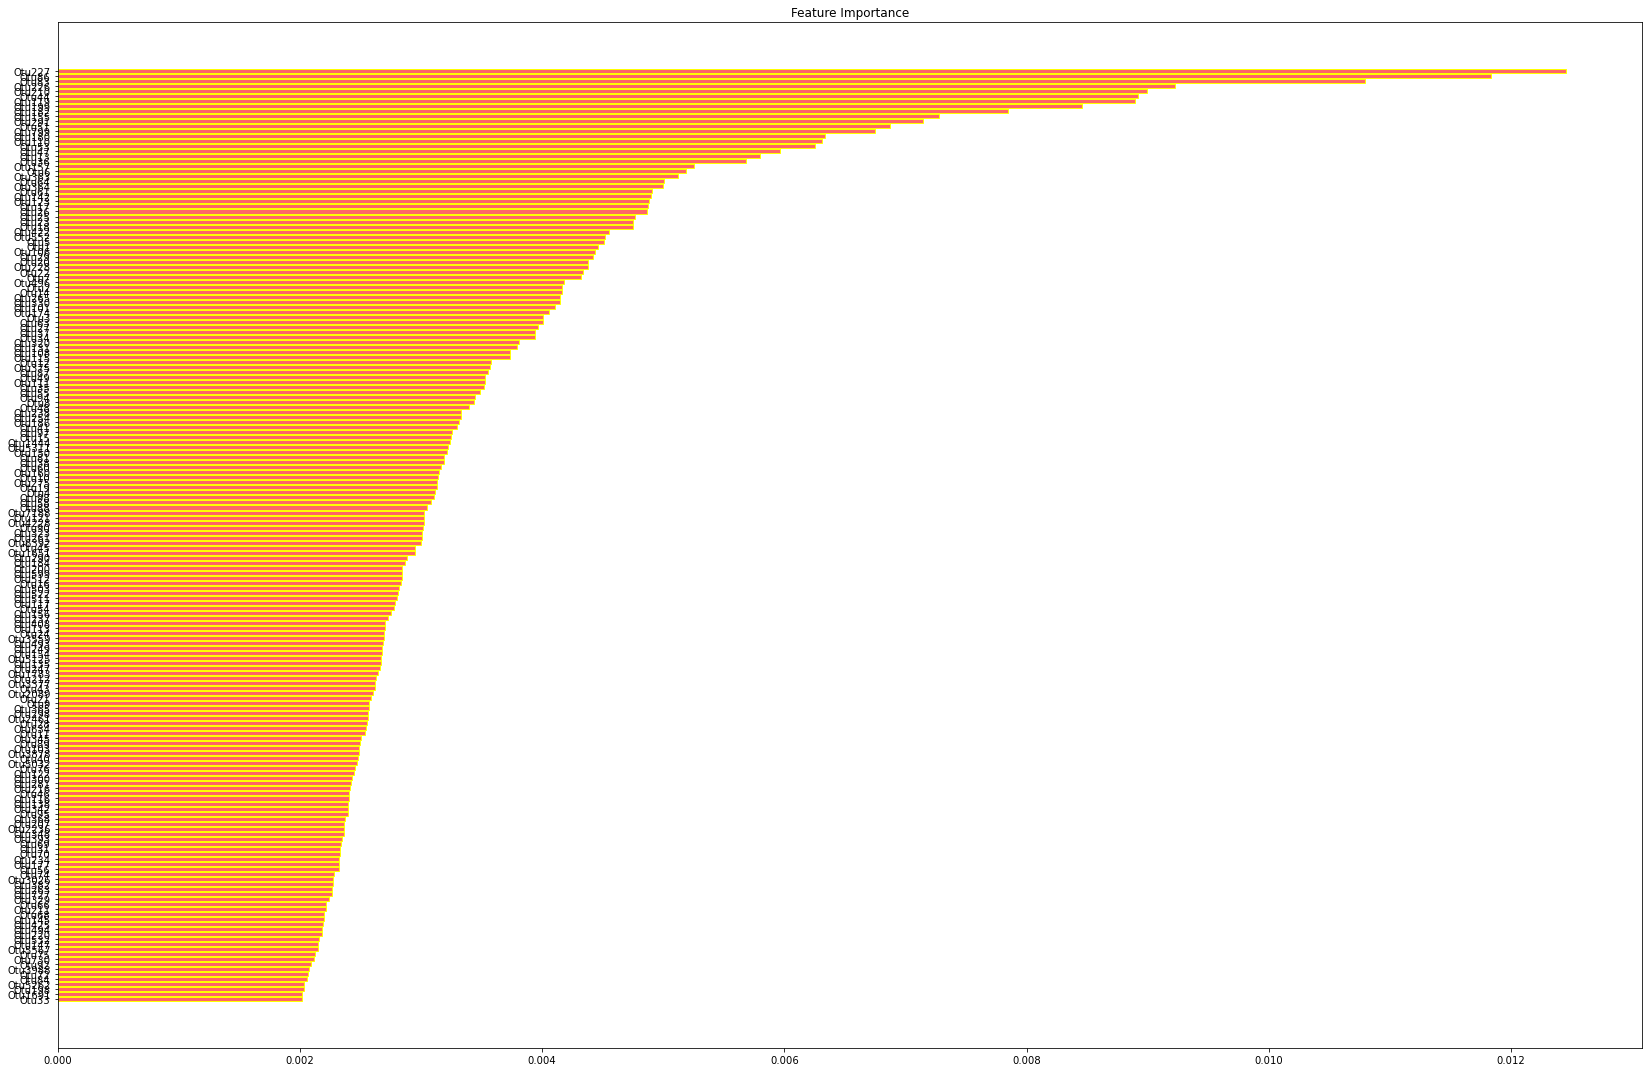

In [51]:
# plot feature importance
indices = np.argsort(filter_feature)
selectn = filter_feature.shape[0]
fig=plt.figure(figsize=(23,15))
ax=fig.add_subplot(111)

ax.barh(range(selectn),filter_feature[indices],facecolor='#FF6666', edgecolor='#FFFF00')
ax.set_yticks(range(selectn))
ax.set_yticklabels(indices[::-1].index)
#ax.set_xlim(0, np.max(indices,)*1.1)
ax.set_title('Feature Importance')
plt.tight_layout()
plt.show()

模型二: Softmax函数做多分类问题-Logistic函数的推广

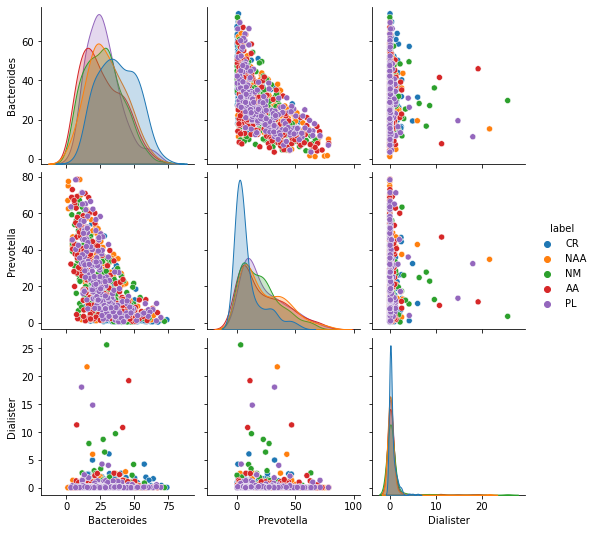

In [6]:
# 可视化数据
data = pd.DataFrame(otu_label[["label","Bacteroides","Prevotella","Dialister"]])
sns.pairplot(data,hue="label")

In [255]:
# sklearn包做逻辑回归-----二分类问题
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
# 训练逻辑回归模型
log_model.fit(xtrain_data, ytrain_index)
# 预测y的值
y_pred = log_model.predict(xtest_data)
# y_pred = log_model.predict(xtrain_data)
# 查看测试结果
print(metrics.confusion_matrix(ytest_index, y_pred))
print(metrics.classification_report(ytest_index, y_pred))

# print(metrics.confusion_matrix(ytrain_index, y_pred))
# print(metrics.classification_report(ytrain_index, y_pred))

[[40  1]
 [13 24]]
              precision    recall  f1-score   support

         0.0       0.75      0.98      0.85        41
         1.0       0.96      0.65      0.77        37

    accuracy                           0.82        78
   macro avg       0.86      0.81      0.81        78
weighted avg       0.85      0.82      0.81        78



E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [248]:
# sklearn包做逻辑回归-----五分类问题
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

std = StandardScaler()
x_train = std.fit_transform(xtrain_data)
x_test = std.fit_transform(xtest_data)
#训练模型
model = LogisticRegression(penalty='l2',C=1,)
model.fit(x_train,Y_train)
y_pred = model.predict(x_test)
# y_pred = model.predict(x_train)

# print(metrics.confusion_matrix(Y_train, y_pred))
# print(metrics.classification_report(Y_train, y_pred))

print(metrics.confusion_matrix(Y_test,y_pred))
print(metrics.classification_report(Y_test, y_pred))

[[10  6 20  3  2]
 [ 5  2 26  3  2]
 [ 2  0 36  1  0]
 [ 6  0 28  5  6]
 [ 0  0  0  1 36]]
              precision    recall  f1-score   support

           0       0.43      0.24      0.31        41
           1       0.25      0.05      0.09        38
           2       0.33      0.92      0.48        39
           3       0.38      0.11      0.17        45
           4       0.78      0.97      0.87        37

    accuracy                           0.45       200
   macro avg       0.44      0.46      0.38       200
weighted avg       0.43      0.45      0.37       200



模型三: 多种弱分类器的集成学习

In [32]:
from sklearn.model_selection import cross_val_score   # 10折交叉验证评价模型
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline   # 管道简化工作流
from sklearn.preprocessing import StandardScaler  # 标准化数据
from sklearn.preprocessing import LabelEncoder   # 标签化分类变量

clf1 = LogisticRegression(penalty='l2',C=0.001)
clf2 = DecisionTreeClassifier()
clf3 = KNeighborsClassifier()

std = StandardScaler()
x_train = std.fit_transform(X_train)
x_test = std.fit_transform(X_test)

pipe1 = Pipeline([['sc',StandardScaler()],['clf',clf1]])
pipe3 = Pipeline([['sc',StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic regression','Decision tree','KNN']
print('10-folds cross validation :\n')
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(clf, x_train, y_train, cv=10)
    print(scores)
    print("ACCURACY: %0.2f(+/- %0.2f)[%s]"%(scores.mean(),scores.std(),label))

10-folds cross validation :

[0.75      0.8125    0.7125    0.6875    0.7375    0.7875    0.725
 0.775     0.725     0.7721519]
ACCURACY: 0.75(+/- 0.04)[Logistic regression]
[0.575      0.5875     0.475      0.6375     0.625      0.6
 0.6        0.625      0.55       0.64556962]
ACCURACY: 0.59(+/- 0.05)[Decision tree]
[0.5625     0.55       0.4375     0.525      0.525      0.6125
 0.5375     0.5875     0.475      0.55696203]
ACCURACY: 0.54(+/- 0.05)[KNN]


In [20]:
# K近邻分类
knn = KNeighborsClassifier()    #实例化KNN模型
knn.fit(X_train, y_train)      #放入训练数据进行训练
# print(knn.predict(X_test))           #打印预测内容
Counter(knn.predict(X_test)==y_test)

Counter({True: 92, False: 108})

In [24]:
# 决策树分类
from sklearn import tree
dtc = tree.DecisionTreeClassifier(criterion="entropy")
clf = dtc.fit(X_train, y_train)
# print(clf.predict(X_test))
Counter(clf.predict(X_test)==y_test)

Counter({True: 125, False: 75})

In [28]:
# 逻辑回归分类
std = StandardScaler()
x_train = std.fit_transform(X_train)
x_test = std.fit_transform(X_test)
#训练模型
model = LogisticRegression(penalty='l2',C=1,)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
Counter(y_pred==y_test)

Counter({True: 161, False: 39})

In [33]:
## 绘制决策树模型------环境变量配置未完成
# from sklearn.datasets import load_iris
# from sklearn import tree
# from sklearn.model_selection import train_test_split
# import graphviz
# import os

# def multi_class_tree():
#     iris = load_iris()
#     x = iris['data']
#     y = iris['target']
#     dtc = tree.DecisionTreeClassifier(criterion="entropy")
#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
#     clf = dtc.fit(x_train, y_train)
#     print(clf.predict(x_test))
#     print(y_test)
#     dot_data = tree.export_graphviz(clf, out_file=None)
#     graph = graphviz.Source(dot_data)
#     os.environ["PATH"] += os.pathsep + 'F:/Program Files/Graphviz2.38/bin/'
#     graph.render("iris", view=True)

# multi_class_tree()

In [35]:
## 我们使用MajorityVoteClassifier集成：
from sklearn.ensemble import VotingClassifier
mv_clf = VotingClassifier(estimators=[('pipe1',pipe1),('clf2',clf2),('pipe3',pipe3)],voting='soft')
clf_labels += ['MajorityVoteClassifier']
all_clf = [pipe1,clf2,pipe3,mv_clf]
print('10-folds cross validation :\n')
for clf,label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator=clf,X=x_train,y=y_train,cv=10)
    print("ACCURACY: %0.2f(+/- %0.2f)[%s]"%(scores.mean(),scores.std(),label))
## 对比下面结果，可以得知多数投票方式的分类算法，抗差能力更强。

10-folds cross validation :

ACCURACY: 0.75(+/- 0.04)[Logistic regression]
ACCURACY: 0.60(+/- 0.05)[Decision tree]
ACCURACY: 0.54(+/- 0.05)[KNN]
ACCURACY: 0.65(+/- 0.05)[MajorityVoteClassifier]


In [41]:
# 基于bagging思想的套袋集成技术
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=None)   #选择决策树为基本分类器
bag = BaggingClassifier(base_estimator=tree,n_estimators=500,max_samples=1.0,max_features=1.0,bootstrap=True,
                        bootstrap_features=False,n_jobs=1,random_state=1)
from sklearn.metrics import accuracy_score
bag = bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train,bag_test))

Bagging train/test accuracies 1.000/0.890


In [45]:
# 基于boosting思想的自适应增强方法----Adaboost集成建模
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print('Adaboost train/test accuracies %.3f/%.3f' % (ada_train,ada_test))

Adaboost train/test accuracies 1.000/0.625


In [53]:
## 1. 简单堆叠3折CV分类
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier

RANDOM_SEED = 42

clf1 = KNeighborsClassifier()
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],  # 第一层分类器
                            meta_classifier=lr,   # 第二层分类器
                            random_state=RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], ['KNN', 'Random Forest', 'Naive Bayes','StackingClassifier']):
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.38 (+/- 0.01) [KNN]
Accuracy: 0.90 (+/- 0.01) [Random Forest]
Accuracy: 0.57 (+/- 0.02) [Naive Bayes]
Accuracy: 0.86 (+/- 0.02) [StackingClassifier]


In [54]:
#  conda install mlxtend --channel conda-forge  安装mlxtend库

In [55]:
## 2.使用概率作为元特征
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            use_probas=True,
                            meta_classifier=lr,
                            random_state=42)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf],
                      ['KNN',
                       'Random Forest',
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train, y_train,
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.38 (+/- 0.01) [KNN]
Accuracy: 0.90 (+/- 0.01) [Random Forest]
Accuracy: 0.57 (+/- 0.02) [Naive Bayes]
Accuracy: 0.84 (+/- 0.03) [StackingClassifier]


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr,
                            random_state=42)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf,
                    param_grid=params,
                    cv=5,
                    refit=True)
grid.fit(X_train, y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  )
E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  )


0.596 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.812 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.640 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.840 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.564 +/- 0.03 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.822 +/- 0.01 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.626 +/- 0.01 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.847 +/- 0.01 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier_

In [57]:
## 4.在不同特征子集上运行的分类器的堆叠
###不同的1级分类器可以适合训练数据集中的不同特征子集。以下示例说明了如何使用scikit-learn管道和ColumnSelector：
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),  # 选择第0,2列
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),  # 选择第1,2,3列
                      LogisticRegression())

sclf = StackingCVClassifier(classifiers=[pipe1, pipe2],
                            meta_classifier=LogisticRegression(),
                            random_state=42)

sclf.fit(X_train, y_train)

E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  )
E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  )
E:\anaconda3\envs\tensorfl

StackingCVClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(0, 2))),
                                                  ('logisticregression',
                                                   LogisticRegression())]),
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(1, 2,
                                                                        3))),
                                                  ('logisticregression',
                                                   LogisticRegression())])],
                     meta_classifier=LogisticRegression(), random_state=42)

E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

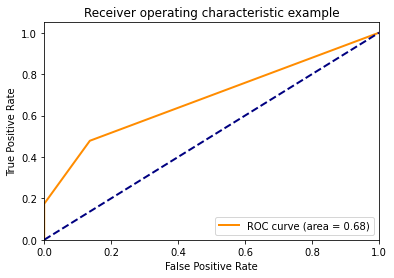

In [21]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2,3,4])
n_classes = y.shape[1]

RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

clf1 =  LogisticRegression()
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = SVC(random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr)


# classifier = OneVsRestClassifier(sclf)
# scores =classifier.fit(X_train, y_train)
# print("Accuracy: %0.2f (+/- %0.2f) "% (scores.mean(), scores.std()))

# Learn to predict each class against the other
classifier = OneVsRestClassifier(sclf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

第四种模型：支持向量机

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
import sklearn.svm as svm
model = svm.SVC(kernel="linear", decision_function_shape="ovo")

In [28]:
def svc(kernel):
    return svm.SVC(kernel=kernel, decision_function_shape="ovo")


def nusvc():
    return svm.NuSVC(decision_function_shape="ovo")


def linearsvc():
    return svm.LinearSVC(multi_class="ovr")


def modelist():
    modelist = []
    kernalist = {"linear", "poly", "rbf", "sigmoid"}
    for each in kernalist:
        modelist.append(svc(each))
    modelist.append(nusvc())
    modelist.append(linearsvc())
    return modelist


def svc_model(model):
    model.fit(X_train, y_train)
    acu_train = model.score(X_train, y_train)
    acu_test = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, average="macro")
    return acu_train, acu_test, recall


def run_svc_model(modelist):
    result = {"kernel": [],
              "acu_train": [],
              "acu_test": [],
              "recall": []
              }

    for model in modelist:
        acu_train, acu_test, recall = svc_model(model)
        try:
            result["kernel"].append(model.kernel)
        except:
            result["kernel"].append(None)
        result["acu_train"].append(acu_train)
        result["acu_test"].append(acu_test)
        result["recall"].append(recall)

    return pd.DataFrame(result)

run_svc_model(modelist())


E:\anaconda3\envs\tensorflow20\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,kernel,acu_train,acu_test,recall
0,sigmoid,0.514393,0.480,0.482943
1,linear,1.000000,0.615,0.623071
2,rbf,0.772215,0.495,0.498928
3,poly,0.758448,0.415,0.425057
4,rbf,0.922403,0.590,0.594562
5,None,0.994994,0.670,0.673904


In [29]:
def test_c():
    result = {"C": [],
              "acu_train": [],
              "acu_test": [],
              "recall": []
              }
    for c in range(10, 101, 10):
        model = svm.SVC(kernel="linear", C=c, decision_function_shape="ovo")
        acu_train, acu_test, recall = svc_model(model)
        result["C"].append(c)
        result["acu_train"].append(acu_train)
        result["acu_test"].append(acu_test)
        result["recall"].append(recall)
    df = pd.DataFrame(result)
    return df
test_c()

,C,acu_train,acu_test,recall
0,10,1.0,0.615,0.623071
1,20,1.0,0.615,0.623071
2,30,1.0,0.615,0.623071
3,40,1.0,0.615,0.623071
4,50,1.0,0.615,0.623071
5,60,1.0,0.615,0.623071
6,70,1.0,0.615,0.623071
7,80,1.0,0.615,0.623071
8,90,1.0,0.615,0.623071
9,100,1.0,0.615,0.623071


In [30]:
def test_degree():
    result = {"degree": [],
              "acu_train": [],
              "acu_test": [],
              "recall": []
              }
    for d in range(1, 11, 1):
        model = svm.SVC(kernel="poly", degree=d, decision_function_shape="ovo")
        acu_train, acu_test, recall = svc_model(model)
        result["degree"].append(d)
        result["acu_train"].append(acu_train)
        result["acu_test"].append(acu_test)
        result["recall"].append(recall)
    df = pd.DataFrame(result)
    return df
    
test_degree()

,degree,acu_train,acu_test,recall
0,1,0.662078,0.520,0.522790
1,2,0.769712,0.500,0.502850
2,3,0.758448,0.415,0.425057
3,4,0.703379,0.405,0.415775
4,5,0.610763,0.325,0.332344
5,6,0.568210,0.270,0.277735
6,7,0.550688,0.240,0.247887
7,8,0.540676,0.225,0.232198
8,9,0.531915,0.220,0.229072
9,10,0.530663,0.225,0.232833


In [40]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

#朴素贝叶斯做多分类
gaussian = GaussianNB()
multi = MultinomialNB()
bernoul = BernoulliNB()
models = [gaussian,multi, bernoul]

def svc_model(model):
    model.fit(X_train, y_train)
    acu_train = model.score(X_train, y_train)
    acu_test = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred, average="macro")
    return acu_train, acu_test, recall

result = {
          "acu_train": [],
          "acu_test": [],
          "recall": []
          }
for each in models:
    acu_train, acu_test, recall = svc_model(each)
    result["acu_train"].append(acu_train)
    result["acu_test"].append(acu_test)
    result["recall"].append(recall)
result = pd.DataFrame(result)
new_col = ['Gaussian', 'Multinomial', 'Bernoulli']
result.index = new_col
result

,acu_train,acu_test,recall
Gaussian,0.881101,0.525,0.534406
Multinomial,0.742178,0.540,0.548558
Bernoulli,0.857322,0.770,0.775513


模型五：xgboost

In [7]:
## Xgboost训练模型
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
#模型参数
param_dict = {'n_estimators':range(50,500,10),
              'max_depth':range(2,15,1),
              'learning_rate':np.linspace(0.01,2,20),
              'subsample':np.linspace(0.6,0.9,20),
              'colsample_bytree':np.linspace(0.5,0.98,10),
              'min_child_weight':range(1,9,1),
              'gamma':[i/10.0 for i in range(0,5)],
              'colsample_bytree':np.linspace(0.6,0.9,20),
              'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
             }
gsearch2 = RandomizedSearchCV(xgb.XGBClassifier(random_state=2050),
                              param_dict,
                              n_iter=20,
                              cv=5,
                              n_jobs=-1)

In [8]:
#在训练集上训练
gsearch2.fit(X_train,y_train,)
print(f'best params:{gsearch2.best_params_}')
# 返回准确率
print('best accuracy:%f' % gsearch2.best_score_)
# 返回最佳训练器
best_estimator = gsearch2.best_estimator_
print(best_estimator)

E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best params:{'subsample': 0.8368421052631579, 'reg_alpha': 1e-05, 'n_estimators': 470, 'min_child_weight': 6, 'max_depth': 2, 'learning_rate': 0.5336842105263158, 'gamma': 0.4, 'colsample_bytree': 0.6631578947368421}
best accuracy:0.924906
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6631578947368421,
              gamma=0.4, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5336842105263158,
              max_delta_step=0, max_depth=2, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=470, n_jobs=16,
              num_paralle

In [9]:
#对训练集进行交叉验证
scores = cross_val_score(best_estimator, X_train, y_train, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#对测试集测试
best_estimator.fit(X_train,y_train)
y_pred=best_estimator.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:17:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.91875   0.93125   0.90625   0.94375   0.9245283]
Accuracy: 0.92 (+/- 0.03)
[13:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\anaconda3\envs\tensorflow20\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.89


# 模型评估

In [85]:
#混淆矩阵
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          CR       0.57      0.33      0.42        12
          FJ       0.00      0.00      0.00         6
          JK       0.46      0.89      0.60        18
          JZ       0.00      0.00      0.00         4
          XR       0.62      0.28      0.38        18

    accuracy                           0.43        58
   macro avg       0.33      0.30      0.28        58
weighted avg       0.45      0.43      0.39        58



In [86]:
array_confusion = metrics.confusion_matrix(y_test, y_pred)
cm = array_confusion
array_confusion = array_confusion.T
array_confusion

array([[ 4,  1,  0,  2,  0],
       [ 0,  0,  0,  0,  3],
       [ 3,  4, 16,  2, 10],
       [ 5,  0,  0,  0,  0],
       [ 0,  1,  2,  0,  5]], dtype=int64)

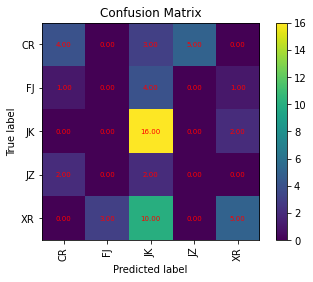

In [87]:
#绘制混淆矩阵图
# disp = metrics.plot_confusion_matrix(gsearch1, X_test, y_test)
# disp.figure_.suptitle("Confusion Matrix")
# print("Confusion matrix:\n%s" % disp.confusion_matrix)

def plot_confusion_matrix(cm,labels,title='Confusion Matrix'):
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array)
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')

labels = ['CR','FJ','JK','JZ','XR'] #五分类
# labels = ['JK','FJ','CR'] #三分类
plot_confusion_matrix(cm,labels)

<ipython-input-48-ef0316edeaaf>:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


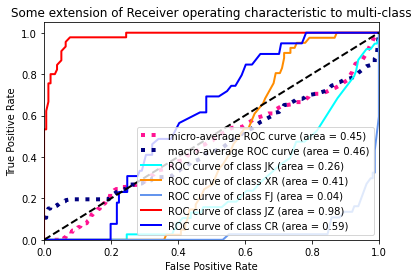

In [48]:
classe = ["JK","XR","FJ","JZ","CR"]
y_test = label_binarize(y_test, classes=["JK","XR","FJ","JZ","CR"])

# 设置种类
n_classes = y_test.shape[1]
y_score = y_test_pred

# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue',"red",'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classe[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [57]:
TP_0 = array_confusion[0,0]
FP_0 = sum(array_confusion[0,1:5])
FN_0 = sum(array_confusion[1:5,0])
TN_0 = sum(array_confusion[1,1:5]+array_confusion[2,1:5]+array_confusion[3,1:5]+array_confusion[4,1:5])-FN_0
# 输出肠癌的灵敏度和特异性
print('肠癌的灵敏度为：%.2f'%(TP_0/(TP_0+FN_0)))
print('肠癌的特异性为：%.2f'%(TN_0/(FP_0+TN_0)))

IndexError: index 3 is out of bounds for axis 0 with size 3

In [96]:
TP_1 = array_confusion[1,1]
FP_1 = array_confusion[1,0]+sum(array_confusion[1,2:5])
FN_1 = array_confusion[0,1]+sum(array_confusion[2:5,1])
TN_1 = sum(array_confusion[0,:5])+sum(array_confusion[2,:5])+sum(array_confusion[3,:5])+sum(array_confusion[4,:5])-FN_1
# 输出非进展的灵敏度和特异性
print('非进展的灵敏度为：%.2f'%(TP_1/(TP_1+FN_1)))
print('非进展的特异性为：%.2f'%(TN_1/(TN_1+FP_1)))

非进展的灵敏度为：0.77
非进展的特异性为：0.98


In [97]:
TP_1 = array_confusion[2,2]
FP_1 = sum(array_confusion[2,0:2])+sum(array_confusion[2,3:5])
FN_1 = sum(array_confusion[0:2,2])+sum(array_confusion[3:5,2])
TN_1 = sum(array_confusion[0,])+sum(array_confusion[1,])+sum(array_confusion[3,])+sum(array_confusion[4,])-FN_1
# 输出健康的灵敏度和特异性
print('健康的灵敏度为：%.2f'%(TP_1/(TP_1+FN_1)))
print('健康的特异性为：%.2f'%(TN_1/(TN_1+FP_1)))

健康的灵敏度为：1.00
健康的特异性为：0.99


In [100]:
TP_1 = array_confusion[3,3]
FP_1 = sum(array_confusion[3,0:3])+sum(array_confusion[3,4:5])
FN_1 = sum(array_confusion[0:3,3])+sum(array_confusion[4:5,3])
TN_1 = sum(array_confusion[0,])+sum(array_confusion[1,])+sum(array_confusion[2,])+sum(array_confusion[4,])-FN_1
# 输出进展的灵敏度和特异性
print('进展的灵敏度为：%.2f'%(TP_1/(TP_1+FN_1)))
print('进展的特异性为：%.2f'%(TN_1/(TN_1+FP_1)))

进展的灵敏度为：0.93
进展的特异性为：0.95


In [99]:
TP_1 = array_confusion[4,4]
FP_1 = sum(array_confusion[4,0:4])
FN_1 = sum(array_confusion[0:4,4])
TN_1 = sum(array_confusion[0,])+sum(array_confusion[1,])+sum(array_confusion[2,])+sum(array_confusion[3,])-FN_1
# 输出息肉的灵敏度和特异性
print('息肉的灵敏度为：%.2f'%(TP_1/(TP_1+FN_1)))
print('息肉的特异性为：%.2f'%(TN_1/(TN_1+FP_1)))

息肉的灵敏度为：0.87
息肉的特异性为：1.00
